In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
import numpy as np
import feature_manager as fma
import rl.env_simple_crypto_trade as env
import importlib
from stable_baselines3 import A2C, PPO
import matplotlib.pyplot as plt


In [ ]:
fm = fma.FeatureManager(target_col="trade_signal")
fm.import_trading_data(symbol="BTCUSDT",trade_timeframe="4h")
fm.import_macro_data(symbol="BTCUSDT",macro_timeframe="1d")
fm.import_super_data(symbol="BTCUSDT",super_timeframe="1w")
FEATURES = [
    "sma_3_10",
    "sma_7_30",
    "rsi14"     
]
fm.build_features(lags = 1,macro_lags=1,super_lags=1,features=FEATURES,macro_features=FEATURES,super_features=FEATURES)


In [ ]:
train = fm.df.iloc[7000:8000]
trade = fm.df.iloc[8000:9000]

In [240]:
state_space = 3 + len(fm.cols)
env_kwargs = {
    "buy_trading_fee" : 0.0002,
    "sell_trading_fee" : 0.0002,
    "money_sleep_cost" : 0.00002,
    "state_space": state_space,
    "indicators": fm.cols,
    "reward_scaling": 1
}

In [228]:
def plot_multiple(result:pd.DataFrame):
    only_first_change = result.loc[result["action"] != result["action"].shift()]
    long = only_first_change.loc[result["action"]==1]
    short = only_first_change.loc[result["action"]==2]
    neutral = only_first_change.loc[result["action"]==0]
    plt.figure(figsize=(12,8),dpi=480)
    plt.plot(result.index,result["cumsum"],c="y")
    plt.plot(result.index,result["relative price"],c="b")
    plt.scatter(long.index,long["relative price"],color="g",marker="o")             #type: ignore
    plt.scatter(neutral.index,neutral["relative price"],color="y",marker="o")       #type: ignore
    plt.scatter(short.index,short["relative price"],color="r",marker="o")           #type: ignore
    plt.show()

def make_result_data(rewards,actions,df):
    result = pd.DataFrame({"return":rewards})
    result.loc[result["return"] == -env_kwargs["money_sleep_cost"],"return"] = 0 #remove opportunity cost
    result["log"] = np.log(result["return"]+1)
    result["cumsum"] = np.exp(result["log"].cumsum(axis=0))
    result["price"] = df["Close"].values
    result["relative price"] = result["price"]/result.iloc[0,:]["price"]
    result["action"] = actions
    print(result["action"].value_counts())
    return result.copy()


In [ ]:
importlib.reload(env)
train_env = env.CryptoTradingEnv(df = train, **env_kwargs)
print(type(train_env))

In [276]:
model = HER('MlpPolicy',train_env,verbose=1)

ImportError: Since Stable Baselines 2.1.0, `HER` is now a replay buffer class `HerReplayBuffer`.
 Please check the documentation for more information: https://stable-baselines3.readthedocs.io/

In [270]:
train_env.reset()
model.learn(total_timesteps=5_000,reset_num_timesteps=False)

It is done
It is done
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.02e+03 |
|    ep_rew_mean     | -0.208   |
| time/              |          |
|    fps             | 387      |
|    iterations      | 1        |
|    time_elapsed    | 5        |
|    total_timesteps | 55296    |
---------------------------------
It is done
It is done
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.02e+03    |
|    ep_rew_mean          | -0.199      |
| time/                   |             |
|    fps                  | 276         |
|    iterations           | 2           |
|    time_elapsed         | 14          |
|    total_timesteps      | 57344       |
| train/                  |             |
|    approx_kl            | 0.005627079 |
|    clip_fraction        | 0.0488      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.974      |
|    explained_variance   | 

In [244]:
trade_env = env.CryptoTradingEnv(df = trade, **env_kwargs)

It is done
2    566
1    223
0    211
Name: action, dtype: int64


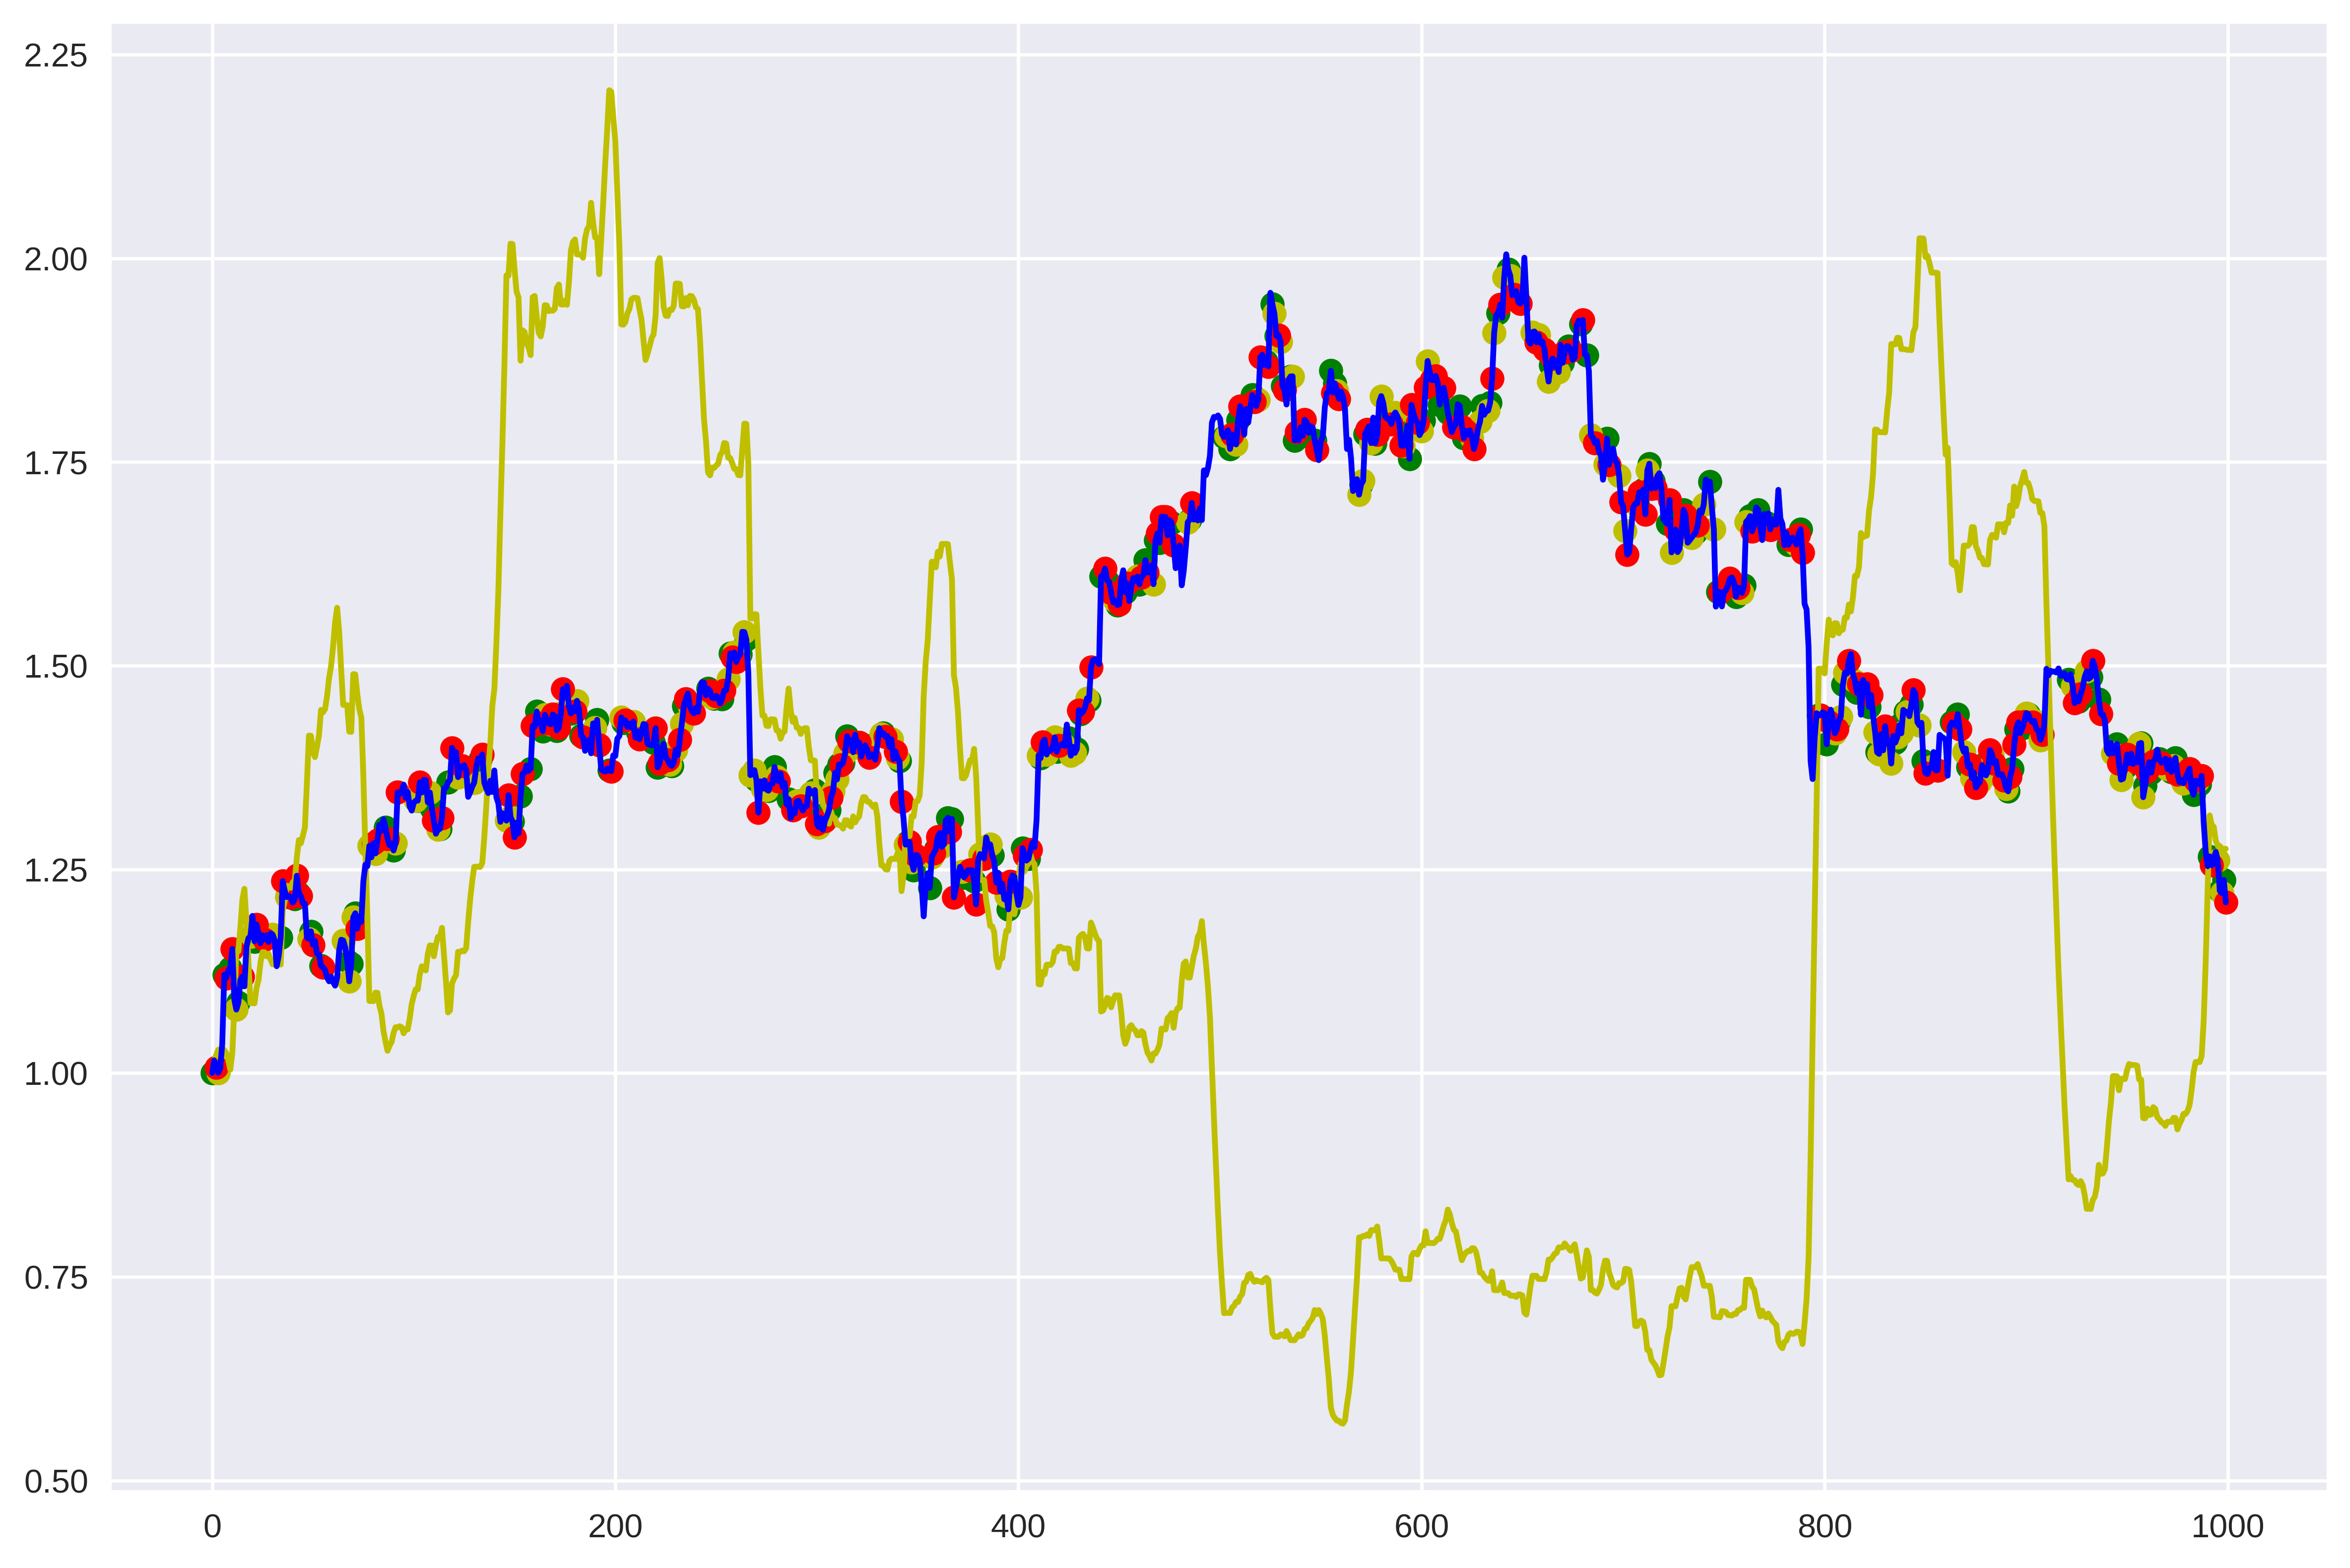

In [275]:
done = False
rewards = []
actions = []
obs = trade_env.reset()
while not done:
    action, states= model.predict(obs)
    obs, reward, done, info = trade_env.step(action)
    rewards.append(reward)
    actions.append(action)

result = make_result_data(rewards=rewards,actions=actions,df=trade_env.df)
plot_multiple(result)